In [1]:
from __future__ import absolute_import, division, print_function

import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# tf.enable_eager_execution()

seed = 7
print(tf.__version__)

1.12.0


In [2]:
def plot_evals_result(evals_result):
    fig, axs = plt.subplots(1,len(set(evals_result.process_step.values,)), figsize=(15, 4))
    steps = list(evals_result.process_step.values)
    steps = sorted(set(steps), key=steps.index)
    for i,process_step in enumerate(steps):
        result = evals_result.loc[(evals_result['process_step'] == process_step),:].reset_index(drop=True)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(process_step+'_mae')
        axs[i].set_ylim(0.0, 0.1)
        axs[i].plot(range(0,len(result)), result['train_mae'], label='Train Error')
        axs[i].plot(range(0,len(result)), result['eval_mae'], label='Val Error')

def plot_TV_P_MPG(pred_result):
    fig, axs = plt.subplots(1,len(set(pred_result.process_step.values,)), figsize=(15, 4))
    steps = list(pred_result.process_step.values)
    steps = sorted(set(steps), key=steps.index)
    for i,process_step in enumerate(steps):
        test_labels = pred_result.loc[(pred_result['process_step'] == process_step),'val_labels'].values
        test_predictions = pred_result.loc[(pred_result['process_step'] == process_step),'val_predictions'].values
        axs[i].set_xlabel('True Values [MPG]')
        axs[i].set_ylabel(process_step+'_Predictions [MPG]')
        axs[i].set_ylim(0, 2)
        axs[i].set_xlim(0, 2)
        axs[i].scatter(test_labels, test_predictions)
    
def plot_PE_MPG(pred_result):
    fig, axs = plt.subplots(1,len(set(pred_result.process_step.values,)), figsize=(15, 4))
    steps = list(pred_result.process_step.values)
    steps = sorted(set(steps), key=steps.index)
    for i,process_step in enumerate(steps):
        test_labels = pred_result.loc[(pred_result['process_step'] == process_step),'val_labels'].values
        test_predictions = pred_result.loc[(pred_result['process_step'] == process_step),'val_predictions'].values
        error = test_predictions - test_labels
        error = pd.DataFrame(error,columns=['price'])
        axs[i].set_xlabel('Prediction Error [MPG]')
        axs[i].set_ylabel(process_step+'_Count')
        axs[i].set_xlim(-1, 1)
#         axs[i].set_ylim(0, 200)
        axs[i].hist(error.price.values, bins = 40)

### 一.基准模型

In [20]:
pcm = pd.read_csv('../tmp/train/province_city_map.csv')
pcm = pcm.loc[:,['city','province','province_id']]
car_source = pd.read_csv('../tmp/train/train.csv')
car_source.loc[(car_source['city'] == '朝阳市'),'city'] = '朝阳'
car_source.loc[(car_source['city'] == '海南州'),'city'] = '海南'

global_model_mean = pd.read_csv('../tmp/train/autohome_global_model_mean.csv')
# 取低配数据
low_config_car = global_model_mean.loc[global_model_mean.groupby(['brand_slug', 'model_slug', 'online_year']).price_bn.idxmin(), :].reset_index(drop=True)
low_config_car = low_config_car.loc[:,['brand_slug','model_slug','online_year','price_bn','median_price']]    
low_config_car = low_config_car.rename(columns={'median_price':'low_config_price','price_bn':'low_config_price_bn'})
# car_source = handle_data_quality(car_source)
# car_source = handle_data_preprocess(car_source)
car_source = car_source.merge(low_config_car,how='left',on=['brand_slug','model_slug','online_year'])
car_source = car_source.loc[:,['title','detail_slug','year','month','mile','city','price','labels','online_year','price_bn','brand_name','model_name','detail_name','low_config_price','low_config_price_bn']]
car_source = car_source.merge(pcm,how='left',on=['city'])

car_source = car_source.loc[(car_source['price'] >= car_source['low_config_price']),:].reset_index(drop=True)

car_source['used_years'] = datetime.datetime.now().year - car_source['online_year']
car_source['warehouse_years'] = car_source['year'] - car_source['online_year']
car_source['div_price_bn'] = car_source['price_bn'] - car_source['low_config_price_bn']
# car_source['price'] = car_source['price'] / car_source['price_bn']
# data = car_source.loc[:,['detail_slug','used_years','warehouse_years','province_id','price','price_bn','low_config_price','div_price_bn']]
data = car_source.loc[:,['detail_slug','used_years','warehouse_years','price','price_bn','low_config_price','div_price_bn']]

train = data.sample(n=100000, random_state=seed).reset_index(drop=True)
test = data.drop(train.index).reset_index(drop=True)
print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
detail_slug         100000 non-null float64
used_years          100000 non-null float64
warehouse_years     100000 non-null float64
price               100000 non-null float64
price_bn            100000 non-null float64
low_config_price    100000 non-null float64
div_price_bn        100000 non-null float64
dtypes: float64(7)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32741 entries, 0 to 32740
Data columns (total 7 columns):
detail_slug         32741 non-null float64
used_years          32741 non-null float64
warehouse_years     32741 non-null float64
price               32741 non-null float64
price_bn            32741 non-null float64
low_config_price    32741 non-null float64
div_price_bn        32741 non-null float64
dtypes: float64(7)
memory usage: 1.7 MB
None None


In [21]:
# train_stats = train.describe()
# train_stats.pop("price")
# train_stats = train_stats.transpose()
# train_stats

# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']

# train_labels = train.pop('price')
# test_labels = test.pop('price')
# normed_train_data = norm(train)
# normed_test_data = norm(test)
columns = list(train.columns)
columns.remove('price')
columns.remove('detail_slug')
normed_train_data, train_labels = train.loc[:,columns], train.loc[:,['price']]
normed_test_data, test_labels = test.loc[:,columns], test.loc[:,['price']]

In [24]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.1)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 400
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_data = (normed_test_data, test_labels), verbose=1, batch_size=1024,
    callbacks=[PrintDot()])

Train on 100000 samples, validate on 32741 samples
Epoch 1/400
100000/100000 [==============================] - 0s 4us/step - loss: 263365.9620 - mean_absolute_error: 48.1648 - val_loss: 64.1751 - val_mean_absolute_error: 6.2698
Epoch 2/400
100000/100000 [==============================] - 0s 2us/step - loss: 50.6364 - mean_absolute_error: 4.1623 - val_loss: 13.8100 - val_mean_absolute_error: 2.9344
Epoch 3/400
100000/100000 [==============================] - 0s 2us/step - loss: 123.9583 - mean_absolute_error: 5.2191 - val_loss: 39.9458 - val_mean_absolute_error: 4.3866
Epoch 4/400
100000/100000 [==============================] - 0s 2us/step - loss: 19.6660 - mean_absolute_error: 2.7544 - val_loss: 6.4396 - val_mean_absolute_error: 2.1327
Epoch 5/400
100000/100000 [==============================] - 0s 2us/step - loss: 13.1255 - mean_absolute_error: 2.2473 - val_loss: 20.5961 - val_mean_absolute_error: 3.2747
Epoch 6/400
100000/100000 [==============================] - 0s 2us/step - loss

Epoch 95/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.2416 - mean_absolute_error: 1.5490 - val_loss: 3.2498 - val_mean_absolute_error: 1.3580
Epoch 96/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.9951 - mean_absolute_error: 1.5613 - val_loss: 2.9202 - val_mean_absolute_error: 1.1891
Epoch 97/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.2079 - mean_absolute_error: 1.5621 - val_loss: 4.9910 - val_mean_absolute_error: 1.5354
Epoch 98/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.0537 - mean_absolute_error: 1.5149 - val_loss: 4.8764 - val_mean_absolute_error: 1.3249
Epoch 99/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.1975 - mean_absolute_error: 1.5490 - val_loss: 1.6299 - val_mean_absolute_error: 0.9293
Epoch 100/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.1002 - mean_absolute_error: 1.5196 - val_loss: 7.4367 -

Epoch 142/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.4564 - mean_absolute_error: 1.5721 - val_loss: 1.7161 - val_mean_absolute_error: 0.9798
Epoch 143/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.0200 - mean_absolute_error: 1.5322 - val_loss: 3.0863 - val_mean_absolute_error: 1.2433
Epoch 144/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.0743 - mean_absolute_error: 1.5276 - val_loss: 11.1346 - val_mean_absolute_error: 1.9273
Epoch 145/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.9913 - mean_absolute_error: 1.4816 - val_loss: 4.1588 - val_mean_absolute_error: 1.4335
Epoch 146/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.1646 - mean_absolute_error: 1.5627 - val_loss: 3.2589 - val_mean_absolute_error: 1.2652
Epoch 147/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.1413 - mean_absolute_error: 1.5646 - val_loss: 5.

Epoch 236/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.8469 - mean_absolute_error: 1.5428 - val_loss: 1.7133 - val_mean_absolute_error: 0.9151
Epoch 237/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.0208 - mean_absolute_error: 1.5143 - val_loss: 3.7624 - val_mean_absolute_error: 1.4188
Epoch 238/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.3555 - mean_absolute_error: 1.6074 - val_loss: 2.8584 - val_mean_absolute_error: 1.0834
Epoch 239/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.8741 - mean_absolute_error: 1.5563 - val_loss: 4.3651 - val_mean_absolute_error: 1.4033
Epoch 240/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.9619 - mean_absolute_error: 1.5518 - val_loss: 6.9290 - val_mean_absolute_error: 1.5594
Epoch 241/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.9894 - mean_absolute_error: 1.5433 - val_loss: 19.

Epoch 330/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.8828 - mean_absolute_error: 1.5243 - val_loss: 9.3467 - val_mean_absolute_error: 1.8103
Epoch 331/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.8720 - mean_absolute_error: 1.5066 - val_loss: 2.7482 - val_mean_absolute_error: 1.0721
Epoch 332/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.9249 - mean_absolute_error: 1.5029 - val_loss: 2.4650 - val_mean_absolute_error: 1.1226
Epoch 333/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.7195 - mean_absolute_error: 1.4942 - val_loss: 16.8169 - val_mean_absolute_error: 2.4667
Epoch 334/400
100000/100000 [==============================] - 0s 2us/step - loss: 5.7601 - mean_absolute_error: 1.4593 - val_loss: 3.8813 - val_mean_absolute_error: 1.2578
Epoch 335/400
100000/100000 [==============================] - 0s 2us/step - loss: 6.0125 - mean_absolute_error: 1.4948 - val_loss: 2.

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
395,5.718506,1.479106,4.562608,1.085892,395
396,6.027599,1.498754,5.104374,1.525090,396
397,5.883083,1.469444,2.017385,1.095923,397
398,5.808940,1.454000,2.534226,1.193718,398
399,5.684651,1.462033,10.922615,1.871045,399


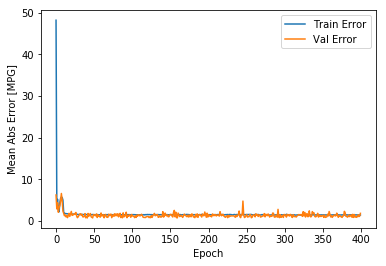

In [27]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,2])
    plt.legend()

plot_history(history)

In [28]:
man = model.predict(normed_test_data)
man

array([[6.508951 ],
       [6.458827 ],
       [6.6193233],
       ...,
       [4.4549026],
       [4.4549026],
       [4.4549026]], dtype=float32)

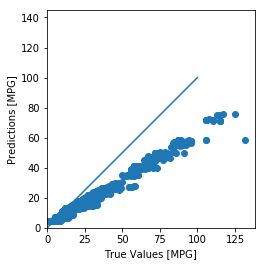

In [29]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
from __future__ import absolute_import, division, print_function

import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.enable_eager_execution()

seed = 7
print(tf.__version__)

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random_normal([NUM_EXAMPLES])
noise = tf.random_normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

In [ ]:
# Define:
# 1. A model.
# 2. Derivatives of a loss function with respect to model parameters.
# 3. A strategy for updating the variables based on the derivatives.
model = Model()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

In [ ]:
# Training loop
for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]),
                            global_step=tf.train.get_or_create_global_step())
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))